In [8]:
import pandas as pd
df = pd.read_csv('/home/mw/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1/Housing.csv')
df.head

<bound method NDFrame.head of         price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0    13300000  7420         4          2        3      yes        no       no   
1    12250000  8960         4          4        4      yes        no       no   
2    12250000  9960         3          2        2      yes        no      yes   
3    12215000  7500         4          2        2      yes        no      yes   
4    11410000  7420         4          1        2      yes       yes      yes   
..        ...   ...       ...        ...      ...      ...       ...      ...   
540   1820000  3000         2          1        1      yes        no      yes   
541   1767150  2400         3          1        1       no        no       no   
542   1750000  3620         2          1        1      yes        no       no   
543   1750000  2910         3          1        1       no        no       no   
544   1750000  3850         3          1        2      yes        no       no  

In [9]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the encoder
le = LabelEncoder()

# Example: Apply LabelEncoder to binary categorical columns
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']  # Add more if needed
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# Check the result
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [10]:
df = pd.get_dummies(df, drop_first=False)
df.head

<bound method NDFrame.head of         price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0    13300000  7420         4          2        3         1          0   
1    12250000  8960         4          4        4         1          0   
2    12250000  9960         3          2        2         1          0   
3    12215000  7500         4          2        2         1          0   
4    11410000  7420         4          1        2         1          1   
..        ...   ...       ...        ...      ...       ...        ...   
540   1820000  3000         2          1        1         1          0   
541   1767150  2400         3          1        1         0          0   
542   1750000  3620         2          1        1         1          0   
543   1750000  2910         3          1        1         0          0   
544   1750000  3850         3          1        2         1          0   

     basement  hotwaterheating  airconditioning  parking  prefarea  \
0          

In [11]:
# Identify boolean columns (if any)
bool_cols = df.select_dtypes(include=[bool]).columns
print("Boolean Columns:", bool_cols)

# Convert boolean columns (True/False) to 1 and 0
for col in bool_cols:
    df[col] = df[col].astype(int)

# Check the result
df.head()


Boolean Columns: Index(['furnishingstatus_furnished', 'furnishingstatus_semi-furnished',
       'furnishingstatus_unfurnished'],
      dtype='object')


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0,0


In [12]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Load your preprocessed tabular data (df), assuming it's already in numeric format
# Example: let's assume df is your final dataset (without the target column)
data = torch.tensor(df.values, dtype=torch.float32)

# Create a DataLoader for the real data
dataset = TensorDataset(data)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [13]:
import torch
from torch import nn
import pytorch_lightning as pl

# Generator model
class Generator(nn.Module):
    def __init__(self, z_dim, input_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, input_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))  # Tanh to scale output to [-1, 1]
        return x


# Discriminator model (Critic for WGAN)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # No sigmoid activation
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Outputs real values for WGAN
        return x


In [14]:
class WGAN(pl.LightningModule):
    def __init__(self, generator, discriminator, z_dim, input_dim, lr=1e-4, weight_clip=0.01, d_steps=5):
        super(WGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.z_dim = z_dim
        self.input_dim = input_dim
        self.lr = lr
        self.weight_clip = weight_clip  # Clipping value for discriminator weights
        self.d_steps = d_steps  # Number of discriminator steps per generator step
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx):
        real_data = batch[0]  # Only the data, no labels
        d_optimizer, g_optimizer = self.optimizers()

        # -----------------
        # Train Discriminator
        # -----------------
        for _ in range(self.d_steps):
            # Generate fake data
            z = torch.randn(real_data.size(0), self.z_dim).to(self.device)
            fake_data = self.generator(z)

            # Compute discriminator loss
            real_loss = -torch.mean(self.discriminator(real_data))  # Real data score
            fake_loss = torch.mean(self.discriminator(fake_data.detach()))  # Fake data score
            d_loss = real_loss + fake_loss

            # Optimize the discriminator
            d_optimizer.zero_grad()
            self.manual_backward(d_loss)
            d_optimizer.step()

            # Clip discriminator weights
            for p in self.discriminator.parameters():
                p.data.clamp_(-self.weight_clip, self.weight_clip)

        # -----------------
        # Train Generator
        # -----------------
        # Generate fake data
        z = torch.randn(real_data.size(0), self.z_dim).to(self.device)
        fake_data = self.generator(z)

        # Compute generator loss
        g_loss = -torch.mean(self.discriminator(fake_data))

        # Optimize the generator
        g_optimizer.zero_grad()
        self.manual_backward(g_loss)
        g_optimizer.step()

        # Log losses
        self.log('d_loss', d_loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('g_loss', g_loss, prog_bar=True, on_step=True, on_epoch=True)

        return g_loss  # Or d_loss, depending on your requirement

    def configure_optimizers(self):
        # Optimizers for both discriminator and generator
        d_optimizer = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)  # RMSprop recommended for WGAN
        g_optimizer = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        return [d_optimizer, g_optimizer], []


In [17]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer

# 1. Load and Prepare Data
# Assuming df is your preprocessed DataFrame (excluding target column) in numeric format
data = torch.tensor(df.values, dtype=torch.float32)

# Create a DataLoader for the real data
dataset = TensorDataset(data)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# 2. Initialize Models
z_dim = 100  # Latent dimension (random noise input for the generator)
input_dim = data.shape[1]  # Number of features in the dataset
generator = Generator(z_dim, input_dim)
discriminator = Discriminator(input_dim)

# 3. Instantiate the WGAN Model
gan = WGAN(generator, discriminator, z_dim=z_dim, input_dim=input_dim, lr=5e-5, weight_clip=0.01, d_steps=5)

# 4. Set Up the Trainer
trainer = Trainer(
    max_epochs=5000,  # Number of epochs for training
    accelerator='gpu',  # Use GPU if available
    devices=1,  # Number of GPUs to use
    log_every_n_steps=10,  # Log every 10 steps
)

# 5. Train the Model
trainer.fit(gan, data_loader)

# 6. Save the Trained Model
trainer.save_checkpoint("wgan_tabular_model.ckpt")

print("Training completed, and the model is saved as 'wgan_tabular_model.ckpt'.")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 49.8 K | train
1 | discriminator | Discriminator | 37.1 K | train
--------------------------------------------------------
86.9 K    Trainable params
0         Non-trainable params
86.9 K    Total params
0.348     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Training completed, and the model is saved as 'wgan_tabular_model.ckpt'.


In [18]:
# Assuming the same setup as in the training script for WGAN model
generator = Generator(z_dim, input_dim)
discriminator = Discriminator(input_dim)

# Load the WGAN model from the checkpoint
gan = WGAN.load_from_checkpoint("wgan_tabular_model.ckpt", 
                                generator=generator, 
                                discriminator=discriminator, 
                                z_dim=z_dim, 
                                input_dim=input_dim, 
                                lr=5e-5,  # Learning rate
                                weight_clip=0.01,  # Weight clip value
                                d_steps=5)  # Number of discriminator steps per generator step

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gan.to(device)

# Ensure the generator and discriminator are also on the same device
gan.generator.to(device)
gan.discriminator.to(device)

print(f"Model successfully loaded to: {device}")


Model successfully loaded to: cuda


In [19]:
gan.generator.eval()
num_samples = 100
z_dim = gan.z_dim

device = next(gan.generator.parameters()).device  # Get the device of the generator
noise = torch.randn(num_samples,z_dim,device=device)
print(f"Generating Noice on: {device}")


with torch.no_grad():
    synthetic_data = gan.generator(noise)
    # print(synthetic_data.shape)

synthetic_data_numpy = synthetic_data.cpu().numpy()
synthetic_df = pd.DataFrame(synthetic_data_numpy, columns=['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus_furnished',
       'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished'])

synthetic_df

Generating Noice on: cuda:0


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,0.999998,0.270124,0.024874,0.022649,-0.023357,0.009353,0.004299,-0.004646,-0.004971,-0.041152,-0.006865,-0.001975,0.031213,-0.006595,0.007810
1,0.999998,-0.775927,-0.020056,-0.034780,-0.014078,-0.016369,-0.005783,-0.030969,-0.023104,0.002439,-0.010719,-0.012535,-0.032825,-0.014745,-0.002325
2,1.000000,0.887300,0.005986,0.016660,-0.002342,0.002367,0.004431,0.027706,-0.003344,0.010411,0.026860,0.001442,0.004877,0.025257,0.005763
3,0.999999,0.715292,0.034897,0.036699,0.009594,0.022669,0.022059,0.010414,-0.007177,0.044129,0.023807,0.054098,0.003640,0.021385,0.004316
4,1.000000,0.981035,-0.003222,-0.043558,0.001793,0.011188,-0.015151,0.033493,0.017060,-0.003507,0.044924,-0.012658,0.014282,-0.004335,0.000119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.000000,-0.968803,-0.004939,-0.005546,0.000904,-0.001075,-0.009034,0.015855,-0.010839,0.013201,-0.004970,0.001733,-0.003657,-0.001218,0.012127
96,0.999999,-0.931208,-0.009200,-0.018275,-0.010560,0.022196,0.003156,-0.007010,-0.021934,0.002368,0.012748,-0.009287,-0.002738,-0.002181,-0.003640
97,0.999996,0.609419,0.003933,0.025535,0.002683,0.011755,0.020103,0.017920,0.013170,0.033281,0.065822,0.050745,0.033538,0.055895,0.037071
98,0.999999,-0.784474,-0.010978,-0.022101,-0.031099,-0.021350,-0.024473,-0.003419,-0.031239,-0.024388,-0.029482,-0.000860,0.011114,-0.018816,-0.021962


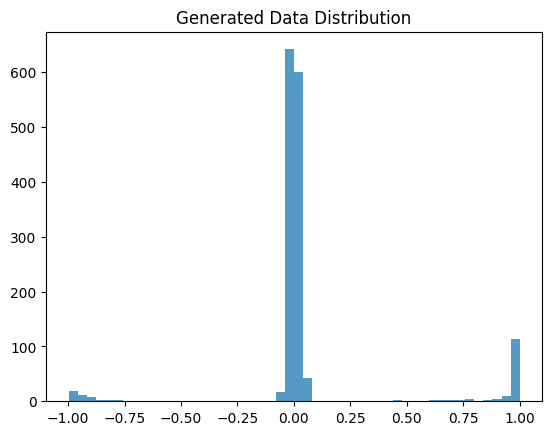

In [21]:
import matplotlib.pyplot as plt
plt.hist(synthetic_data_numpy
.flatten(), bins=50, alpha=0.75)
plt.title('Generated Data Distribution')
plt.show()


In [23]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance

gan.generator.eval()
num_samples = len(df.values)
z_dim = gan.z_dim

device = next(gan.generator.parameters()).device  # Get the device of the generator
noise = torch.randn(num_samples,z_dim,device=device)
print(f"Generating Noice on: {device}")


with torch.no_grad():
    generated_data = gan.generator(noise)

# Compare feature distributions (example for a specific feature)
real_data = df.values  # Replace with actual real data
generated_data = generated_data.cpu().numpy()  # Convert to numpy array
# Compare distributions for a specific feature using KS test or Wasserstein distance
for feature in range(real_data.shape[1]):
    real_feature = real_data[:, feature]
    generated_feature = generated_data[:, feature]
    
    # Wasserstein distance
    w_distance = wasserstein_distance(real_feature, generated_feature)
    print(f"Feature {feature}: Wasserstein Distance = {w_distance}")
    
    # Or use a statistical test like KS test
    # ks_stat, ks_p_value = stats.ks_2samp(real_feature, generated_feature)
    # print(f"Feature {feature}: KS test p-value = {ks_p_value}")


Generating Noice on: cuda:0
Feature 0: Wasserstein Distance = 4766728.2477075625
Feature 1: Wasserstein Distance = 5150.520801413663
Feature 2: Wasserstein Distance = 2.962216576416026
Feature 3: Wasserstein Distance = 1.284834368055026
Feature 4: Wasserstein Distance = 1.8023361757705243
Feature 5: Wasserstein Distance = 0.8580296287451413
Feature 6: Wasserstein Distance = 0.18198275108818482
Feature 7: Wasserstein Distance = 0.3497671317627414
Feature 8: Wasserstein Distance = 0.05572089235289786
Feature 9: Wasserstein Distance = 0.3158839057158004
Feature 10: Wasserstein Distance = 0.6907353061570151
Feature 11: Wasserstein Distance = 0.237360064247292
Feature 12: Wasserstein Distance = 0.25878361905134634
Feature 13: Wasserstein Distance = 0.41633613003127345
Feature 14: Wasserstein Distance = 0.3278271231988291
